In [8]:
import torch
from data import CIFAR10DataModule
import biopytorch.biolinear as biolinear
import biopytorch.biotrainer as bio_train
from plotting import plot_rgb_filters
from biopytorch.bioconv2d import BioConv2d
from biopytorch.biotrainer import bio_train
from plotting import plot_rgb_filters
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, lr_scheduler
from tqdm.notebook import tqdm
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from time import time
from ignite.metrics import Accuracy, Loss
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup, LRScheduler
from torchvision import transforms
from torch.utils.data import DataLoader

## The main porperties of a convolutional layer:

- **Local receptive fields**: each neuron receives input only form a patch of the image.

- **Weight sharing**: the same set of weights (kernel) is used for all teh receptive fields.

Why in image classification convolutional layers outperform fully connected layers:

1. **Local receptive fields**
    - Patterns in images are mostly local.
    - Different scales can be captured by tweaking the kernel size, or by rescaling
        the inputs (e.g. through maxpooling).
    - Inspired by retinal ganglion cells and V1 neurons in the primary visual cortex.

2. **Weight sharing**
    - Ability to detect the same pattern in different position in the image.
    - Images can be described by few “universal” patterns that can appear in any
    position.
    - Fewer weights to learn improve performance and help against overfitting

### How do we learn convolutional layers with the bio-inspired rule?

A convolutional kernel is just a perceptron working on patches,

<center>
<img src = "../../data/project/convKernel.png" style = "width:500px;">
</center>

So, by unfolding patches and kernels, the setup is the same as the traditional one.

Futhermore, different kernels compete the same way as neurons in the standard feed forward setup did. The Hebbian teerm is just the sum of different patches weighted by the activations.

### Drawback
The efficiency of this strategy is dragged down mainly two factors. First of all the number of patches scales as the square of the image size (assuming `padding` = "valid") e.g. with *CIFAR10* ($32 \times 32$ images) and a $5 \times 5$ kernel  we have $28^2 = 784 patches$.
The second hurdle is represented that by the lack of optimization for the operations we want to perform while $2d$ convolution are estensively optimized by the main libraries.

To fix this problem we transform this problem into a convolution. We can find the Hebbian term as,

$$
\text{Hebbian term} = H_{\nu} = \sum_{\mu} P_{\mu \nu} \cdot A_{\mu}; \quad H_{1} = \sum_{\mu} P_{\mu 1} A_{\mu} = \langle P_{\mu 1} A_{\mu} \rangle
$$

So we rewrote a generic Hebbian term as an inner product between $1-d$ vectors. The first of the $2$ vectors is formed by all the first pixels of each patch forming a grid of near-by pixels. The inner product can thus be rewritten as the convolution between this latter grid and a properly reshaped post activation values.

In [9]:
print("Torch version:", torch.__version__)

#Select device for training
#device = "cpu" #For this very simple dataset it is actually faster
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #Uncomment for GPU 

print(f'Using "{device}" for training')

Torch version: 1.12.0
Using "cpu" for training


In [10]:
#composed_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomResizedCrop(32)])
cifar10 = CIFAR10DataModule(batch_size = 64)#, train_data_transform = composed_transform)
cifar10.setup()

Files already downloaded and verified
Files already downloaded and verified


In [11]:
def plot_filters_callback(weights):
    plot_rgb_filters(weights[:5])

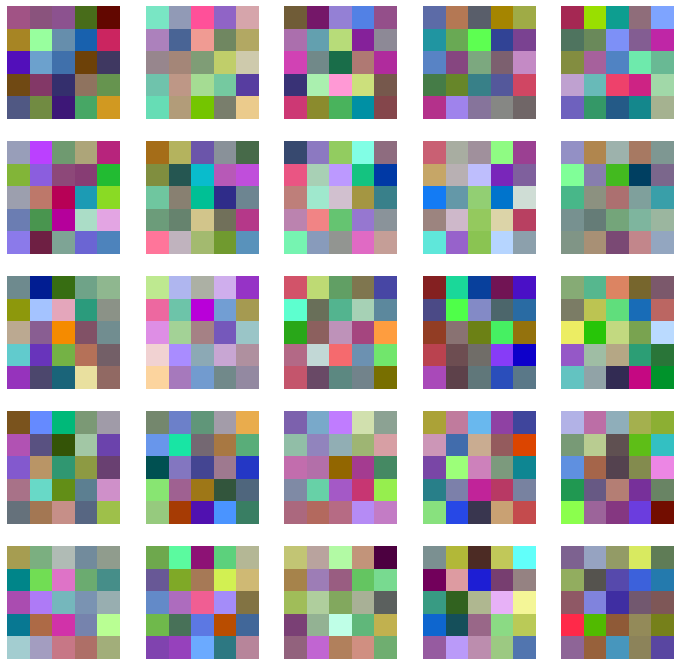

In [12]:
bioconv = BioConv2d(in_channels = 3, out_channels = 96, kernel_size=5, ranking_param=2, lebesgue_p=3, delta=.2) #delta=.05 works too
#plot_rgb_filters(bioconv.weight.cpu())
plot_rgb_filters(bioconv.weight.cpu())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

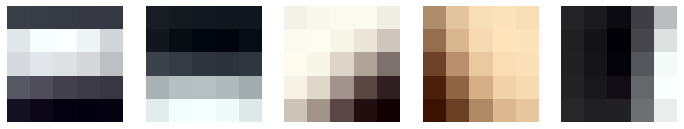

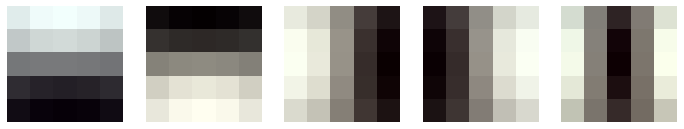

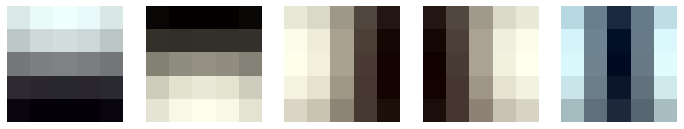

<Figure size 432x288 with 0 Axes>

In [13]:
bio_train(bioconv, cifar10, n_epochs=5, epoch_callback=plot_filters_callback, lr_scheduler=(.007, .0001, .8), device = device)
plt.savefig("bioconvWeights.png")

In [14]:
#torch.save(bioconv.weight, "weightsCIFAR")

In [5]:
bioconv_weights = torch.load("weightsCIFAR")

## Supervised phase

In [6]:
class Net(nn.Module):
    def __init__(self, weights, out_classes = 10, n = 4.5, beta = .1):
        
        super(Net, self).__init__()
        self.weights = weights
        #self.conv = BioConv2d(in_channels = 3, out_channels = 96, kernel_size=5, ranking_param=2, lebesgue_p=3, delta=.2)
        self.fc = nn.Linear(14*14*96, out_classes)
        self.n = n
        self.beta = beta

    def forward(self, x):
        x = F.conv2d(x, self.weights)
        x = F.relu(x) #** self.n
        x = nn.MaxPool2d(2)(x)
        x = nn.BatchNorm2d(96)(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class BioLoss(nn.Module):
    """Loss introduced in eq. 12 of [1]
    
    [1]: "Unsupervised learning by competing hidden units", D. Krotov, J. J. Hopfield, 2019, 
         https://www.pnas.org/content/116/16/7723
    """
    
    def __init__(self,
                 output_dim : int = 10,
                 m : int = 6):
        
        super().__init__()
        
        self.output_dim = output_dim
        self.m = m

    def forward(self, predicted, true_val): 
        one_hot = torch.eye(self.output_dim, dtype=torch.float, device=predicted.device)[true_val]
        #Convert true values to one hot encoding
        one_hot[one_hot == 0] = -1 #Substitute 0s with -1 (spin-like one hot encoding)
        
        loss = (predicted - one_hot).abs() ** self.m
        
        return torch.sum(loss)

In [7]:
model = Net(weights=bioconv_weights, out_classes=10, n=4.5, beta=.1)

# Adjust the learning rate

In [8]:
#loss=BioLoss(10) 
loss = nn.CrossEntropyLoss()

In [13]:
### Training function
epochs = 8
def run_test(train_dl, test_dl, batch_size=64, lr=1e-3, verbose=0):
    #From https://github.com/gatapia/unsupervised_bio_classifier/blob/master/src/bio_learn2.py
    #(Standard training code)
    
    start = time()
    train_dl = train_dl
    test_dl = test_dl
        
    optimizer = Adam(model.parameters(), lr=lr)    
    #create_supervised_trainer is a factory function (a function that returns a new object) for creating a trainer for supervised models
    trainer = create_supervised_trainer(model, optimizer, loss)
    evaluator = create_supervised_evaluator(model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss)})
    
    pbar = tqdm(initial=0, leave=False, total=epochs, desc=f"ITERATION") #Progress bar
    
    train_err = []
    test_err  = []
    torch_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    scheduler = create_lr_scheduler_with_warmup(torch_lr_scheduler, warmup_start_value=0.0, warmup_end_value=lr, warmup_duration=5)
    # Basic usage of ignite's create_supervised_trainer function
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
    #EPOCH_COMPLETED : triggered when the epoch is ended. Note that this is triggered even when terminate_epoch() is called.
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_epoch(trainer):
        evaluator.run(train_dl)
        metrics = evaluator.state.metrics
        train_acc = metrics['accuracy']
        
        evaluator.run(test_dl)
        metrics = evaluator.state.metrics
        test_acc = metrics['accuracy']
        
        train_err.append( 100 * (1. - train_acc) )
        test_err.append( 100 * (1. - test_acc ) )
        
        pbar.desc = f"ITERATION - accuracy (train): {train_acc:.3f} - accuracy (test) : {test_acc:.3f}"
        pbar.update(1)

    # COMPLETED : triggered when engine’s run is completed
    @trainer.on(Events.COMPLETED)
    def log_complete(engine):
        evaluator.run(test_dl)        
        print("Final Accuracy: {:.2f} Took: {:.0f}s".format(evaluator.state.metrics['accuracy'], time() - start))

    trainer.run(train_dl, max_epochs=epochs) 
    
    return train_err, test_err

In [14]:
run_test(cifar10.train_dataloader(), cifar10.test_dataloader())

ITERATION:   0%|          | 0/8 [00:00<?, ?it/s]

Final Accuracy: 0.51 Took: 429s


([48.262499999999996,
  38.334999999999994,
  38.739999999999995,
  37.8625,
  41.9075,
  40.7825,
  39.0125,
  34.69],
 [57.220000000000006,
  50.629999999999995,
  50.17,
  50.36000000000001,
  53.620000000000005,
  52.81,
  52.269999999999996,
  49.46])

In [2]:
100 - 49.46

50.54

In [15]:
#net_state_dict = model.state_dict()
# Save the state dict to a file
#torch.save(net_state_dict, 'netCIFAR.torch')